In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as scs
import scipy.special as scl
import scipy.integrate as spint
import scipy.interpolate as spinterp
import scipy.fft as scft

In [2]:
def purefringes(y_detector,parameters, delta_p=0, printvals = False):
    """
    This function calculates the fringe pattern for given parameters and detector y coordinates. 
    This function does not take into account the fresnel diffraction effect from the slats.
    """
     # baseline_len, theta_offaxis, theta_b, beam_width, L, wavelength,
    # parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

    # Define required values from dict
    baseline_len = parameters['baseline_len']
    theta_offaxis = parameters['theta_offaxis']
    beam_width = parameters['beam_width']
    L = parameters['L']
    theta_b = parameters['beam_width'] / parameters['L']
    wavelength = parameters['wavelength']
    
    # y_0 is the central point of the fringes on the detector.
    y_0 = -baseline_len * np.sin(theta_offaxis) / (2 * np.sin(theta_b/2)) + delta_p
    # Re-define coordinate system such that y_prime is 0 for the central fringe
    y_prime = y_detector - y_0

    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    if printvals:
        
        # print(f'The expected fringe spacing is {fringe_spacing:.2e} m')
        # print(f'The expected centre of the fringes is at {y_0:.2e} m')
        pass

    return fringe_amp, fringe_spacing, y_0, y_prime

def fresnel_diff(y_detector, parameters, delta_p=0, printvals = False):
    """
    Calculates the fresnel diffraction pattern for given set of parameters
    """

    # Define required values from dict
    baseline_len = parameters['baseline_len']
    theta_offaxis = parameters['theta_offaxis']
    beam_width = parameters['beam_width']
    L = parameters['L']
    theta_b = parameters['beam_width'] / parameters['L']
    wavelength = parameters['wavelength']
    
    y_0 = -L * theta_offaxis
    y_prime = y_detector - y_0
    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    u_1 = u - u_0/2
    u_2 = u + u_0/2
    
    C_1, S_1 = scl.fresnel(u_1)
    # print('Integral',C_1)
    C_2, S_2 = scl.fresnel(u_2)

    # print(C_1, S_2)

    A = C_2 - C_1 + 1j*(S_2 - S_1)
    # plt.plot(np.abs(A)**2)
    # plt.show()
    

    if printvals:
        
        # print(f'The expected fringe spacing is {fringe_spacing:.2e} m')
        # print(f'The expected centre of the fringes is at {y_0:.2e} m')
        pass

    return A, y_prime, y_0

In [3]:
def calc_single(y_val, parameters, delta_p=0):
    """
    Calculates the amplitude for a single given y-axis position.
    """

    # Define required values from dict
    baseline_len = parameters['baseline_len']
    theta_offaxis = parameters['theta_offaxis']
    beam_width = parameters['beam_width']
    L = parameters['L']
    theta_b = parameters['beam_width'] / parameters['L']
    wavelength = parameters['wavelength']
    
    # Fringe Pattern
    y_0 = -baseline_len * np.sin(theta_offaxis) / (2 * np.sin(theta_b/2)) + delta_p
    y_prime = y_val - y_0

    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    A_fringe = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b
    
    
    # Fresnel Diffraction
    y_0 = -L * theta_offaxis
    y_prime = y_val - y_0
    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    u_1 = u - u_0/2
    u_2 = u + u_0/2
    
    C_1, S_1 = scl.fresnel(u_1)
    # print('Integral',C_1)
    C_2, S_2 = scl.fresnel(u_2)

    # print(C_1, S_2)

    A_fresnel = C_2 - C_1 + 1j*(S_2 - S_1)

    A_full = A_fresnel * A_fringe
    return A_full

In [4]:
def GenerateSamples(sample_size,parameters, ret_ph_count = False, vary_P = False, delta_P_inp = 0):
    # D = 1 # 1 Meter baseline
    # W = 300*1e-6 # 300 um
    # L = 10 # in m
    # theta_b = W / L
    # wavelength = 10 * 1e-10 # 10 A
    # print(theta_b)
    y_detector_max = 0.0003
    y = np.linspace(-y_detector_max, y_detector_max, 5000)
    res = (.0003 + .0003)/5000
    # print('Current Resolution of Detector (m)', res)

    # Calculate Max of I based on max at theta=0, delta_P = 0
    delta_P = 0
    # theta =5e-6 # Off axis angle
    A_pure, fringe_spacing, center_pure, y_prime = purefringes(y, parameters, delta_P)
    A_fresnel, y_prime, center_f = fresnel_diff(y, parameters, delta_P)
    
    A_full = A_pure * A_fresnel
    I = np.abs(A_full)**2
    I_max = np.max(I)
    
    # print(f'The maximum instensity is {I_max}')

    
    # Sampling
    
    size_samples = sample_size # The number of samples taken per readout

    # Sample y pixel coord and I value using y_max and I_max resepctively
    y_sample = np.random.uniform(size = size_samples) * y_detector_max * 2 - y_detector_max
    I_sample = np.random.uniform(size = size_samples) * I_max


    
    
    # delta_P = np.random.uniform(size = size_samples) * 1e4 * wavelength # Re-define variation here later!
    # if vary_P:
    #     delta_P = np.random.uniform(size = size_samples) * 2e-4
    # else:
    #     delta_P = np.random.uniform(size = size_samples) * 2e-5 * 0
    # y_sample = np.random.uniform(size = size_samples) * y_detector_max * 2 - y_detector_max
    # I_sample = np.random.uniform(size = size_samples) * I_max
    
    # # Calculate 'true' values of each sampled y pixel based on random delta_P and other parameters
    # I_true = np.abs(calc_single(y_sample, parameters, delta_P))**2

    # # Compare sampled I value with true value to accept/reject
    # accepted_y, accepted_I = y_sample[I_sample <= I_true], I_sample[I_sample <= I_true]
    # rejected_y, rejected_I = y_sample[I_sample > I_true], I_sample[I_sample > I_true]

    # # print(f'There were {len(accepted_y)} photons detected')
    # n_accepted = len(accepted_y)
    
    
    accepted_y = np.array([])
    rejected_y = np.array([])
    accepted_I = np.array([])
    rejected_I = np.array([])

    y_sample = np.random.uniform(size = 1) * y_detector_max * 2 - y_detector_max
    I_sample = np.random.uniform(size = 1) * I_max

    n_accepted = len(accepted_y)
    accept_rate = 0.2
    while n_accepted < sample_size:
        # Generate a large number of samples based on how many more we need:
        n_samples = int((sample_size - n_accepted) / accept_rate)
        to_accept = sample_size - n_accepted
        if vary_P:
            delta_P = np.ones(shape = n_samples) * delta_P_inp
        else:
            delta_P = np.random.uniform(size = n_samples) * 0
            
    
        y_sample = np.random.uniform(size = n_samples) * y_detector_max * 2 - y_detector_max
        I_sample = np.random.uniform(size = n_samples) * I_max
        I_true = np.abs(calc_single(y_sample, parameters, delta_P))**2

        accepted_y_temp, accepted_I_temp = y_sample[I_sample <= I_true], I_sample[I_sample <= I_true]
        rejected_y_temp, rejected_I_temp = y_sample[I_sample > I_true], I_sample[I_sample > I_true]
        if len(accepted_y_temp) < to_accept:
        # print(accepted_y_temp)
            accepted_y = np.append(accepted_y, accepted_y_temp)
            accepted_I = np.append(accepted_I, accepted_I_temp)
            rejected_y = np.append(rejected_y, rejected_y_temp)
            rejected_I = np.append(rejected_I, rejected_I_temp)
        else:
            accepted_y = np.append(accepted_y, accepted_y_temp[:to_accept])
            accepted_I = np.append(accepted_I, accepted_I_temp[:to_accept])
            rejected_y = np.append(rejected_y, rejected_y_temp)
            rejected_I = np.append(rejected_I, rejected_I_temp)
        
        n_accepted = len(accepted_y)
        # print(accepted_y)
        # print(n_accepted, n_samples)
        
        # if I_sample<=I_true:
        #     accepted_y.append(y_sample)
        #     accepted_I.append(I_sample)
        # else:
        #     rejected_y.append(y_sample)
        #     rejected_I.append(I_sample)
        

    n_accepted = len(accepted_y)
    
    if not ret_ph_count:
        return accepted_y, accepted_I, rejected_y, rejected_I
    else:
        return accepted_y, accepted_I, rejected_y, rejected_I, n_accepted

0.19177661859466094
0.24195499637067505
0.25343403112169904


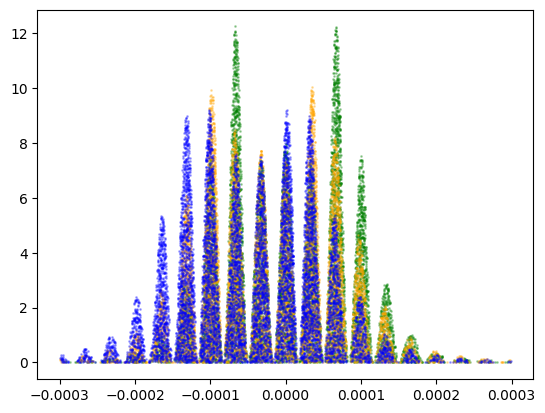

In [5]:
parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='green', markersize=2, alpha=.3)

parameters = {'baseline_len':10, 'theta_offaxis':2e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='orange', markersize=2, alpha=.3)

parameters = {'baseline_len':10, 'theta_offaxis':5e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='blue', markersize=2, alpha=.3)
# plt.plot(rejected_y, rejected_I, '.', color='red', markersize=2)
plt.show()

0.1900634812027217
0.18983256767531037


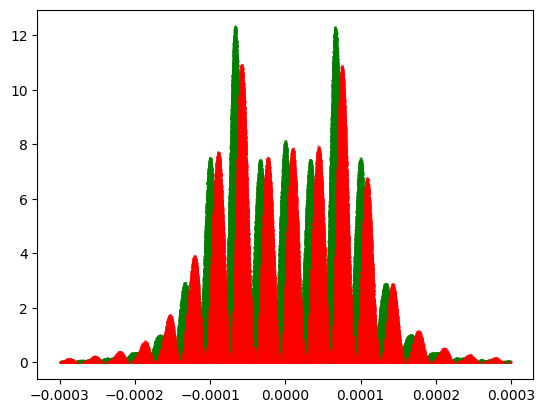

In [6]:
parameters = {'baseline_len':10, 'theta_offaxis':0, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(100000, parameters)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='green', markersize=2, alpha=.4)

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(100000, parameters, vary_P = True, delta_P_inp = 1e-5)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='red', markersize=2, alpha=.4)



# parameters = {'baseline_len':10, 'theta_offaxis':2e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

# accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters, vary_P = True)
# print(len(accepted_y)/len(rejected_y))
# plt.plot(accepted_y, accepted_I, '.', color='orange', markersize=2, alpha=.4)

# parameters = {'baseline_len':10, 'theta_offaxis':5e-6, 'beam_width':300e-6, 'L':10, 'wavelength':10e-10}

# accepted_y, accepted_I, rejected_y, rejected_I = GenerateSamples(10000, parameters, vary_P = True)
# print(len(accepted_y)/len(rejected_y))
# plt.plot(accepted_y, accepted_I, '.', color='blue', markersize=2, alpha=.4)
# plt.plot(rejected_y, rejected_I, '.', color='red', markersize=2)
plt.show()

Expected Noise Power: 0.6
Total accepted no. of ph: 2000


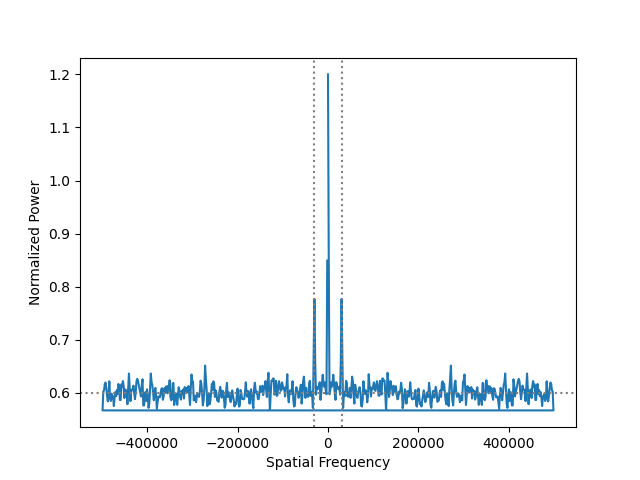

In [13]:
plt.close()
yf_list = []
accepted_photons = []
n_exp = int(1e3)
n_ph_per_exp = 2
for i in range(n_exp):
    delta_P = np.random.uniform(size = 1) * 1e-2
    accepted_y, accepted_I, rejected_y, rejected_I, n_ph = GenerateSamples(n_ph_per_exp, parameters, vary_P = True, ret_ph_count = True, delta_P_inp = delta_P)
    accepted_photons.append(n_ph)
    n_bins = 600
    spacing = (2 * 0.0003) / n_bins
    bins_y = np.linspace(-0.0003, -.0003 + spacing * n_bins, n_bins, endpoint=True)
    counts, edges = np.histogram(accepted_y, bins=bins_y)
    
    # plt.step(edges[:-1], counts/100)
    # plt.show()
    
    # if np.sum(counts>0):
    
    # Define Fourier Frequencies:
    N = len(edges) - 1 # Number of bins
    min_freq = 1/N
    max_freq = 1/2 * (1/N)
    # print(min_freq, max_freq)
    
    # Take the Fourier Transform
    yf = scft.fft(counts)
    
    # Normalize
    # yf = 2 * n_bins * np.abs(yf)**2 / (np.sum(counts)**2)
    yf = np.abs(yf)**2
    yf_list.append(yf)
    
    # Define the corresponding frequencies
    xf = scft.fftfreq(N, edges[1]-edges[0])
# print(accepted_photons)
yf_list = np.array(yf_list)
sum_yf = np.sum(yf_list, axis=0)
tot_accepted_ph = np.sum(accepted_photons)
norm_yf = 2 * (n_bins / tot_accepted_ph**2) * sum_yf
P_noise = 2 * n_bins / tot_accepted_ph

val = np.argsort(sum_yf)[-4]-1
val_2 = 0

print('Expected Noise Power:', P_noise)
print('Total accepted no. of ph:', tot_accepted_ph)
plt.plot(xf, norm_yf)
# plt.plot(xf, sum_yf)
plt.axvline(30000, linestyle='dotted', color='grey')
plt.axvline(-30000, linestyle='dotted', color='grey')
plt.axhline(P_noise, linestyle='dotted', color='grey')
plt.ylabel('Normalized Power')
plt.xlabel('Spatial Frequency')
plt.savefig(f'NormalizedPowerSpectrum_{n_exp}Exp_{n_ph_per_exp}PhotonsPerExp.pdf', dpi=300)
plt.show()

Text(0, 0.5, 'Probability of Power(nu) > Power(noise)')

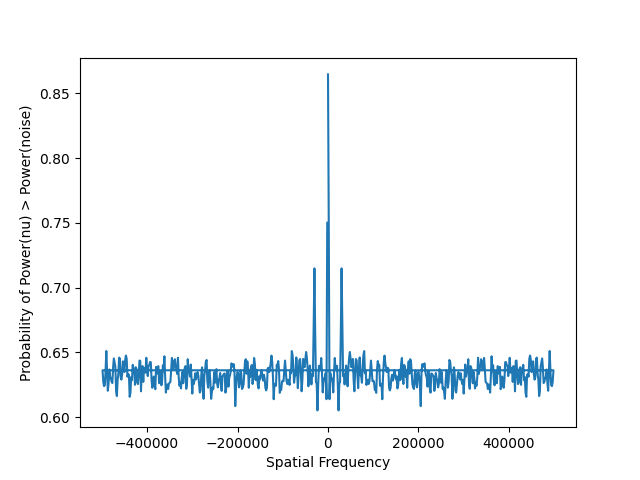

In [11]:
%matplotlib widget
plt.close()
SNR = norm_yf/P_noise
prob = 1-np.exp(-SNR)
plt.plot(xf, prob)
plt.xlabel('Spatial Frequency')
plt.ylabel('Probability of Power(nu) > Power(noise)')
# plt.savefig(f'Probabiility{n_exp}Exp_{n_ph_per_exp}PhotonsPerExp.pdf', dpi=300)

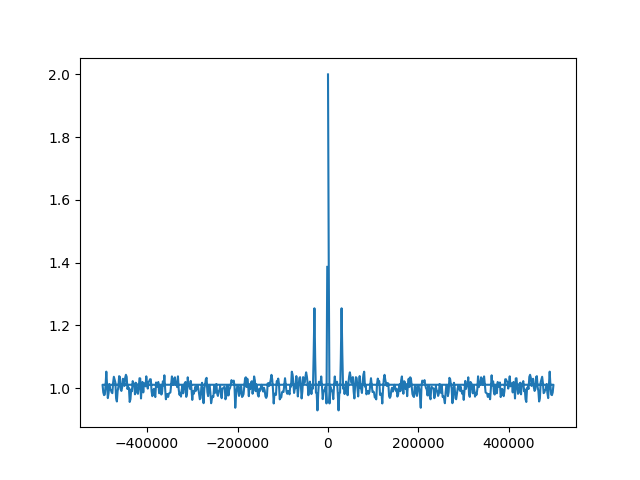

In [12]:
plt.close()
plt.plot(xf, SNR)
plt.show()

In [14]:
print(0.779/P_noise)

1.2983333333333333
